In [1513]:
# from google.colab import drive
# drive.mount('/content/drive')

In [1514]:
# from zipfile import ZipFile
# zf = ZipFile('Datasets.zip')
# zf.extractall()
# zf.close()

## Gathering Data

We have collected the Data from various resources that includes
1. Data collected from official website of `United States Environmental Protection Agency` which contains pre-generated data of 'Criteria gases, Particulates(Air pollutants), Meteorological' on Daily basis. Link: https://aqs.epa.gov/aqsweb/airdata/download_files.html
2. Trips by Distance data gathered from the webiste of `U.S. Department of Transportation` (https://data.bts.gov/Research-and-Statistics/Trips-by-Distance/w96p-f2qv)
3. US State COVID 19 dataset obtained from the `GitHub` : https://github.com/nytimes/covid-19-data/tree/master/live 


## Data Preparation

### Airquality Index Datasets(AQI) - Criteria gases,  Cleaning and Merging

In [2]:
#%cd /content/drive/MyDrive/Info-I project/Datasets

#### Reading CSV files using Pandas

In [20]:
import pandas as pd
aqi_df_2020 = pd.read_csv('AQI/daily_aqi_by_county_2020.csv')
aqi_df_2021 = pd.read_csv('AQI/daily_aqi_by_county_2021.csv')
aqi_df_2022 = pd.read_csv('AQI/daily_aqi_by_county_2022.csv')

In [21]:
aqi_df_2022.head()

,State Name,county Name,State Code,County Code,Date,AQI,Category,Defining Parameter,Defining Site,Number of Sites Reporting
0,Alabama,Baldwin,1,3,2022-01-02,22,Good,PM2.5,01-003-0010,1
1,Alabama,Baldwin,1,3,2022-01-05,36,Good,PM2.5,01-003-0010,1
2,Alabama,Baldwin,1,3,2022-01-08,35,Good,PM2.5,01-003-0010,1
3,Alabama,Baldwin,1,3,2022-01-11,15,Good,PM2.5,01-003-0010,1
4,Alabama,Baldwin,1,3,2022-01-14,48,Good,PM2.5,01-003-0010,1


In [22]:
aqi_df_2022.columns

Index(['State Name', 'county Name', 'State Code', 'County Code', 'Date', 'AQI',
       'Category', 'Defining Parameter', 'Defining Site',
       'Number of Sites Reporting'],
      dtype='object')

#### Feature selection or Removing irrelevant Data

In [23]:
aqi_2020 = aqi_df_2020[['Date','State Name', 'AQI']]
aqi_2021 = aqi_df_2021[['Date','State Name', 'AQI']]
aqi_2022 = aqi_df_2022[['Date','State Name', 'AQI']]

#### Concatenating Datasets along axis =0 (row)

In [24]:
aqi_df = pd.concat([aqi_2020,aqi_2021,aqi_2022],axis = 0, ignore_index = True)
aqi_df.head()

,Date,State Name,AQI
0,2020-01-01,Alabama,48
1,2020-01-04,Alabama,13
2,2020-01-07,Alabama,14
3,2020-01-10,Alabama,39
4,2020-01-13,Alabama,29


In [25]:
aqi_df['Date'].min(),aqi_df['Date'].max()

('2020-01-01', '2022-11-02')

#### Renaming Columns of a Dataframe

In [26]:
# aqi_df.rename(columns={'county Name':'County Name'},inplace= True)

In [27]:
# Removing spaces begining and end of the string and coverting it to title.
# aqi_df['County Name'] = aqi_df['County Name'].apply(lambda x : x.strip().title())
aqi_df['State Name'] = aqi_df['State Name'].apply(lambda x : x.strip().title())
aqi_df['Date'] = aqi_df['Date'].apply(lambda x : x.strip())

#### Checking and handling Outliers

In [28]:
aqi_df.describe()

,AQI
count,853012.000000
mean,39.046880
std,25.021704
min,0.000000
25%,28.000000
50%,37.000000
75%,46.000000
max,7577.000000


Here we can observe that mean value of AQI is 39.046 and std is 25.02 and maximum value it could be mean+st = 39.046+25.0217 = 64.06, but from the descriptive statistics the max value is 7,577 which is far more greater than the 64.06. So, from this we observed that there are outliers that needs to be handled.

#### Outlier detection through box plot

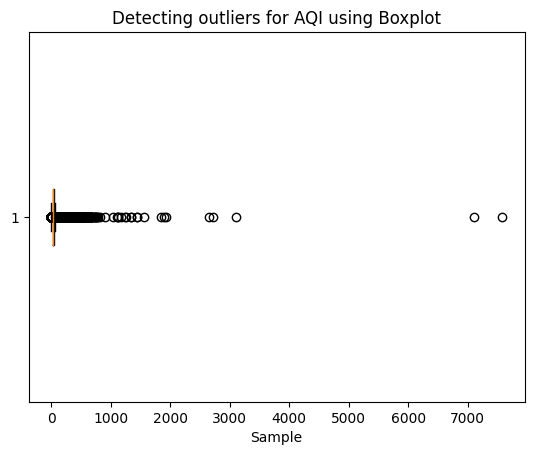

In [29]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.boxplot(aqi_df['AQI'], vert=False)
plt.title("Detecting outliers for AQI using Boxplot")
plt.xlabel('Sample')
plt.show()

From this visualization, we can see the outliers

#### Outlier detection using Inter Quantile Range(IQR)

In [30]:
outliers = []
def detect_outliers_iqr(data):
    data = sorted(data)
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    # print(q1, q3)
    IQR = q3-q1
    lwr_bound = q1-(1.5*IQR)
    upr_bound = q3+(1.5*IQR)
    # print(lwr_bound, upr_bound)
    for i in data: 
        if (i<lwr_bound or i>upr_bound):
            outliers.append(i)
    return outliers

sample_outliers = detect_outliers_iqr(aqi_df['AQI'])
print("Outliers from IQR method in percentage: ", (len(sample_outliers)/aqi_df.shape[0])*100)

Outliers from IQR method in percentage:  4.685631620657154


#### Handling Outliers

##### Handling outliers through Quantile based flooring and capping

In [31]:
import pandas as pd
def flooring_capping(series):
    original_data = series
    sorted_data = sorted(series)
    q1 = np.percentile(sorted_data, 25)
    q3 = np.percentile(sorted_data, 75)
    # print(q1, q3)
    IQR = q3-q1
    lwr_bound = q1-(1.5*IQR)
    upr_bound = q3+(1.5*IQR)
    print(lwr_bound, upr_bound)
    corrected_list = []
    for i in original_data: 
        if i<lwr_bound:
            corrected_list.append(lwr_bound)
        elif i>upr_bound:
            corrected_list.append(upr_bound)
        else:
            corrected_list.append(i)
    return pd.Series(corrected_list)

aqi_df['AQI'] = flooring_capping(aqi_df['AQI'])


1.0 73.0


#### checking outliers after handling it

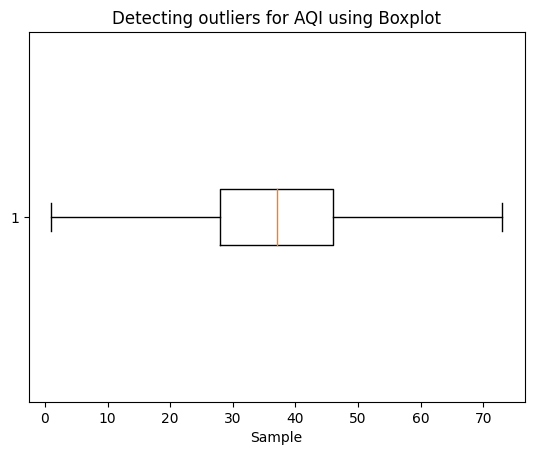

In [32]:
plt.boxplot(aqi_df['AQI'], vert=False)
plt.title("Detecting outliers for AQI using Boxplot")
plt.xlabel('Sample')
plt.show()

In [33]:
aqi_df.head()

,Date,State Name,AQI
0,2020-01-01,Alabama,48.0
1,2020-01-04,Alabama,13.0
2,2020-01-07,Alabama,14.0
3,2020-01-10,Alabama,39.0
4,2020-01-13,Alabama,29.0


In [34]:
# aqi_states_list = list(aqi_df['State Name'].unique())

In [37]:
aqi_df[(aqi_df['Date']=='2020-01-01')&(aqi_df['State Name']=='Alabama')]

,Date,State Name,AQI
0,2020-01-01,Alabama,48.0
377,2020-01-01,Alabama,38.0
938,2020-01-01,Alabama,28.0
1216,2020-01-01,Alabama,49.0
1582,2020-01-01,Alabama,8.0
1672,2020-01-01,Alabama,37.0
2036,2020-01-01,Alabama,54.0
2384,2020-01-01,Alabama,57.0
2745,2020-01-01,Alabama,20.0
3100,2020-01-01,Alabama,57.0


In [38]:
aqi_df = aqi_df.groupby(['Date','State Name']).mean().reset_index()
aqi_df.head()

,Date,State Name,AQI
0,2020-01-01,Alabama,36.666667
1,2020-01-01,Alaska,27.250000
2,2020-01-01,Arizona,43.307692
3,2020-01-01,Arkansas,35.454545
4,2020-01-01,California,55.358491


#### Checking and Removing duplicate values in a dataframe

In [39]:
aqi_df.duplicated(subset=['Date','State Name']).value_counts()

False    52157
dtype: int64

There are no duplicated values present in the dataframe, not required to handle duplicate values

In [40]:
aqi_df.shape

(52157, 3)

#### Checking for null Values

In [41]:
aqi_df.isna().value_counts()

Date   State Name  AQI  
False  False       False    52157
dtype: int64

No null values are present in the AQI dataset after concatenation

In [112]:
# %cd /home/students/divenna/info_project/Datasets/AQI/

# aqi_df.to_csv('aqi_df.csv',index=False) # Saving the dataframe to CSV file

In [113]:
# aqi_df = pd.read_csv('aqi_df.csv')
# aqi_df.head()

### Air Pollutants Merging and Cleaning

In [114]:
%cd /home/students/divenna/info_project/Datasets

/home/students/divenna/info_project/Datasets


#### Reading CSV files using Pandas

In [1]:
import pandas as pd


In [2]:
pm10_2020_df = pd.read_csv('airpollutants/daily_pm10_2020.csv')
pm10_2021_df = pd.read_csv('airpollutants/daily_pm10_2021.csv')
pm10_2022_df = pd.read_csv('airpollutants/daily_pm10_2022.csv')

In [3]:
pm2_2020_df = pd.read_csv('airpollutants/daily_pm2.5_2020.csv')
pm2_2021_df = pd.read_csv('airpollutants/daily_pm2.5_2021.csv')
pm2_2022_df = pd.read_csv('airpollutants/daily_pm2.5_2022.csv')

/tmp/ipykernel_725301/344075545.py:2: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  pm2_2021_df = pd.read_csv('airpollutants/daily_pm2.5_2021.csv')
/tmp/ipykernel_725301/344075545.py:3: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  pm2_2022_df = pd.read_csv('airpollutants/daily_pm2.5_2022.csv')


In [4]:
co_2020_df = pd.read_csv('airpollutants/daily_co_2020.csv')
co_2021_df = pd.read_csv('airpollutants/daily_co_2021.csv')
co_2022_df = pd.read_csv('airpollutants/daily_co_2022.csv')

In [5]:
no2_2020_df = pd.read_csv('airpollutants/daily_no2_2020.csv')
no2_2021_df = pd.read_csv('airpollutants/daily_no2_2021.csv')
no2_2022_df = pd.read_csv('airpollutants/daily_no2_2022.csv')

In [6]:
ozone_2020_df = pd.read_csv('airpollutants/daily_ozone_2020.csv')
ozone_2021_df = pd.read_csv('airpollutants/daily_ozone_2021.csv')
ozone_2022_df = pd.read_csv('airpollutants/daily_ozone_2022.csv')

In [7]:
so2_2020_df = pd.read_csv('airpollutants/daily_so2_2020.csv')
so2_2021_df = pd.read_csv('airpollutants/daily_so2_2021.csv')
so2_2022_df = pd.read_csv('airpollutants/daily_so2_2022.csv')

#### Feature selection or Removing irrelevant Data

In [8]:
pm10_2020 = pm10_2020_df[['Date Local','State Name','Arithmetic Mean']]
pm10_2021 = pm10_2021_df[['Date Local','State Name','Arithmetic Mean']]
pm10_2022 = pm10_2022_df[['Date Local','State Name','Arithmetic Mean']]

pm2_2020 = pm2_2020_df[['Date Local','State Name','Arithmetic Mean']]
pm2_2021 = pm2_2021_df[['Date Local','State Name','Arithmetic Mean']]
pm2_2022 = pm2_2022_df[['Date Local','State Name','Arithmetic Mean']]

co_2020 = co_2020_df[['Date Local','State Name','Arithmetic Mean']]
co_2021 = co_2021_df[['Date Local','State Name','Arithmetic Mean']]
co_2022 = co_2022_df[['Date Local','State Name','Arithmetic Mean']]

no2_2020 = no2_2020_df[['Date Local','State Name','Arithmetic Mean']]
no2_2021 = no2_2021_df[['Date Local','State Name','Arithmetic Mean']]
no2_2022 = no2_2022_df[['Date Local','State Name','Arithmetic Mean']]

ozone_2020 = ozone_2020_df[['Date Local','State Name','Arithmetic Mean']]
ozone_2021 = ozone_2021_df[['Date Local','State Name','Arithmetic Mean']]
ozone_2022 = ozone_2022_df[['Date Local','State Name','Arithmetic Mean']]

so2_2020 = so2_2020_df[['Date Local','State Name','Arithmetic Mean']]
so2_2021 = so2_2021_df[['Date Local','State Name','Arithmetic Mean']]
so2_2022 = so2_2022_df[['Date Local','State Name','Arithmetic Mean']]

#### Concatenating the Dataframes along axis =0 (row)

In [9]:
pm10_df = pd.concat([pm10_2020,pm10_2021,pm10_2022],axis = 0, ignore_index = True)
pm2_df = pd.concat([pm2_2020,pm2_2021,pm2_2022],axis = 0, ignore_index = True)
co_df = pd.concat([co_2020,co_2021,co_2022],axis = 0, ignore_index = True)
no2_df = pd.concat([no2_2020,no2_2021,no2_2022],axis = 0, ignore_index = True)
ozone_df = pd.concat([ozone_2020,ozone_2021,ozone_2022],axis = 0, ignore_index = True)
so2_df = pd.concat([so2_2020,so2_2021,so2_2022],axis = 0, ignore_index = True)

In [10]:
pm10_df.shape[0],pm2_df.shape[0],co_df.shape[0],no2_df.shape[0],ozone_df.shape[0],so2_df.shape[0]

(436218, 1507227, 453393, 409327, 1016008, 805837)

#### Renaming columns

In [11]:
pm10_df.rename(columns = {'Arithmetic Mean':'pm10_mean','Date Local':'Date'}, inplace = True)
pm2_df.rename(columns = {'Arithmetic Mean':'pm25_mean','Date Local':'Date'}, inplace = True)
co_df.rename(columns = {'Arithmetic Mean':'co_mean','Date Local':'Date'}, inplace = True)
no2_df.rename(columns = {'Arithmetic Mean':'no2_mean','Date Local':'Date'}, inplace = True)
ozone_df.rename(columns = {'Arithmetic Mean':'o3_mean','Date Local':'Date'}, inplace = True)
so2_df.rename(columns = {'Arithmetic Mean':'so2_mean','Date Local':'Date'}, inplace = True)

### Checking and handling Outliers

#### Outlier detection through box plot

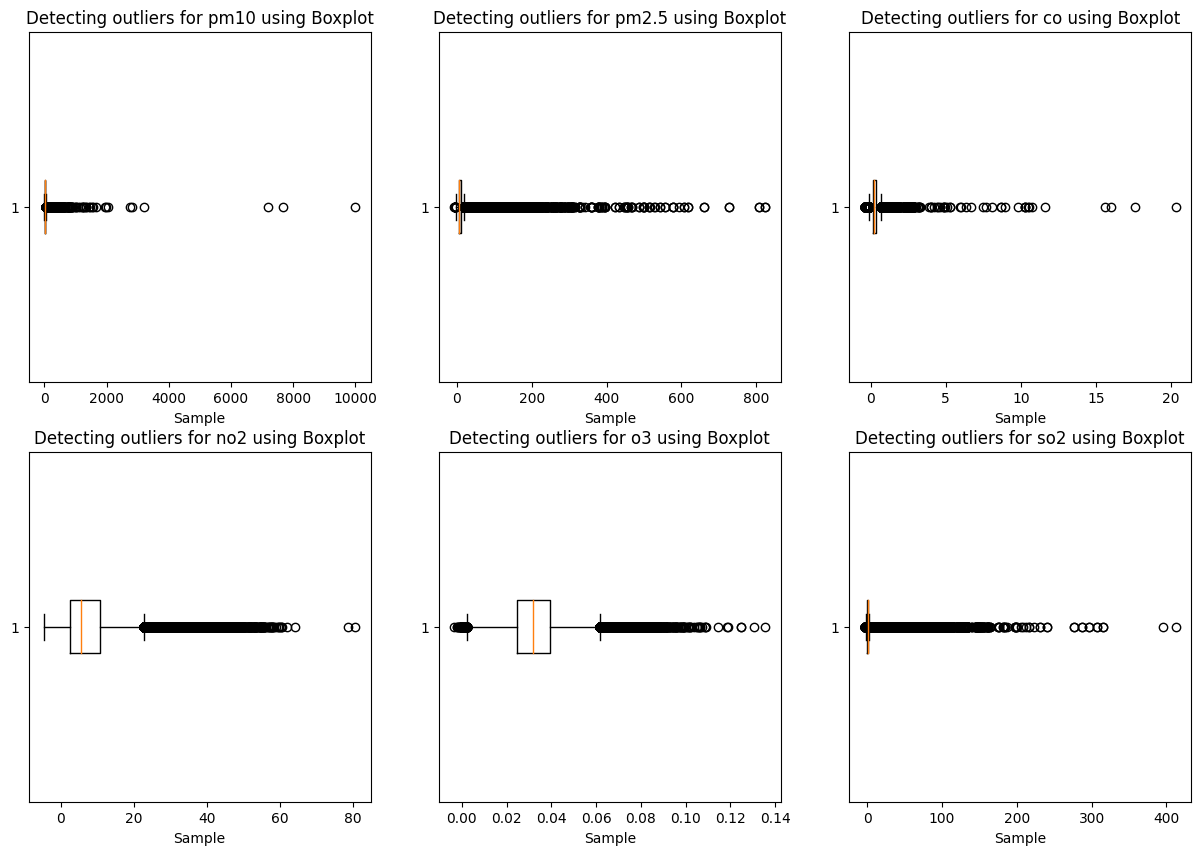

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (15, 10))

plt.subplot(2,3, 1)
plt.boxplot(pm10_df['pm10_mean'], vert=False)
plt.title("Detecting outliers for pm10 using Boxplot")
plt.xlabel('Sample')


plt.subplot(2,3,2)
plt.boxplot(pm2_df['pm25_mean'], vert=False)
plt.title("Detecting outliers for pm2.5 using Boxplot")
plt.xlabel('Sample')



plt.subplot(2,3,3)
plt.boxplot(co_df['co_mean'], vert=False)
plt.title("Detecting outliers for co using Boxplot")
plt.xlabel('Sample')


plt.subplot(2,3,4)
plt.boxplot(no2_df['no2_mean'], vert=False)
plt.title("Detecting outliers for no2 using Boxplot")
plt.xlabel('Sample')


plt.subplot(2,3,5)
plt.boxplot(ozone_df['o3_mean'], vert=False)
plt.title("Detecting outliers for o3 using Boxplot")
plt.xlabel('Sample')


plt.subplot(2,3,6)
plt.boxplot(so2_df['so2_mean'], vert=False)
plt.title("Detecting outliers for so2 using Boxplot")
plt.xlabel('Sample')
plt.show()


From above box plots we can observe that each pollutant has some outliers and needs to be handled.

#### Outlier detection using Inter Quantile Range(IQR)

In [14]:
import numpy as np

In [15]:
def detect_outliers_iqr(data):
    outliers = []
    data = sorted(data)
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    # print(q1, q3)
    IQR = q3-q1
    lwr_bound = q1-(1.5*IQR)
    upr_bound = q3+(1.5*IQR)
    # print(lwr_bound, upr_bound)
    for i in data: 
        if (i<lwr_bound or i>upr_bound):
            outliers.append(i)
    return outliers
    
sample_outliers = detect_outliers_iqr(pm10_df['pm10_mean'])
print(f"Outliers for pm10 from IQR method in percentage: ", (len(sample_outliers)/pm10_df.shape[0])*100)

sample_outliers = detect_outliers_iqr(pm2_df['pm25_mean'])
print(f"Outliers for pm2.5 from IQR method in percentage: ", (len(sample_outliers)/pm2_df.shape[0])*100)

sample_outliers = detect_outliers_iqr(co_df['co_mean'])
print(f"Outliers for co from IQR method in percentage: ", (len(sample_outliers)/co_df.shape[0])*100)

sample_outliers = detect_outliers_iqr(no2_df['no2_mean'])
print(f"Outliers for no2 from IQR method in percentage: ", (len(sample_outliers)/no2_df.shape[0])*100)

sample_outliers = detect_outliers_iqr(ozone_df['o3_mean'])
print(f"Outliers for ozone from IQR method in percentage: ", (len(sample_outliers)/ozone_df.shape[0])*100)

sample_outliers = detect_outliers_iqr(so2_df['so2_mean'])
print(f"Outliers for so2 from IQR method in percentage: ", (len(sample_outliers)/so2_df.shape[0])*100)

Outliers for pm10 from IQR method in percentage:  6.063023534104508
Outliers for pm2.5 from IQR method in percentage:  5.039254206566098
Outliers for co from IQR method in percentage:  4.350530334610371
Outliers for no2 from IQR method in percentage:  4.224983937047886
Outliers for ozone from IQR method in percentage:  0.5919244730356454
Outliers for so2 from IQR method in percentage:  6.730145178243243


From above IQR method we observe that every pollutant has outliers which is small portion of the overall data (6.6%, 5%,4%)

#### Handling Outliers

##### Handling outliers through Quantile based flooring and capping

In [16]:
import pandas as pd
def flooring_capping(series):
    original_data = series
    sorted_data = sorted(series)
    q1 = np.percentile(sorted_data, 25)
    q3 = np.percentile(sorted_data, 75)
    # print(q1, q3)
    IQR = q3-q1
    lwr_bound = q1-(1.5*IQR)
    upr_bound = q3+(1.5*IQR)
    print(lwr_bound, upr_bound)
    corrected_list = []
    for i in original_data: 
        if i<lwr_bound:
            corrected_list.append(lwr_bound)
        elif i>upr_bound:
            corrected_list.append(upr_bound)
        else:
            corrected_list.append(i)
    return pd.Series(corrected_list)

pm10_df['pm10_mean'] = flooring_capping(pm10_df['pm10_mean'])
pm2_df['pm25_mean'] = flooring_capping(pm2_df['pm25_mean'])
co_df['co_mean'] = flooring_capping(co_df['co_mean'])
no2_df['no2_mean'] = flooring_capping(no2_df['no2_mean'])
ozone_df['o3_mean'] = flooring_capping(ozone_df['o3_mean'])
so2_df['so2_mean'] = flooring_capping(so2_df['so2_mean'])

-15.5 52.5
-3.6000000000000014 18.0
-0.12968700000000002 0.6511450000000001
-9.480434999999998 22.745652999999997
0.0022364999999999954 0.06152850000000001
-1.1652174999999998 2.1391305


#### checking outliers after handling it

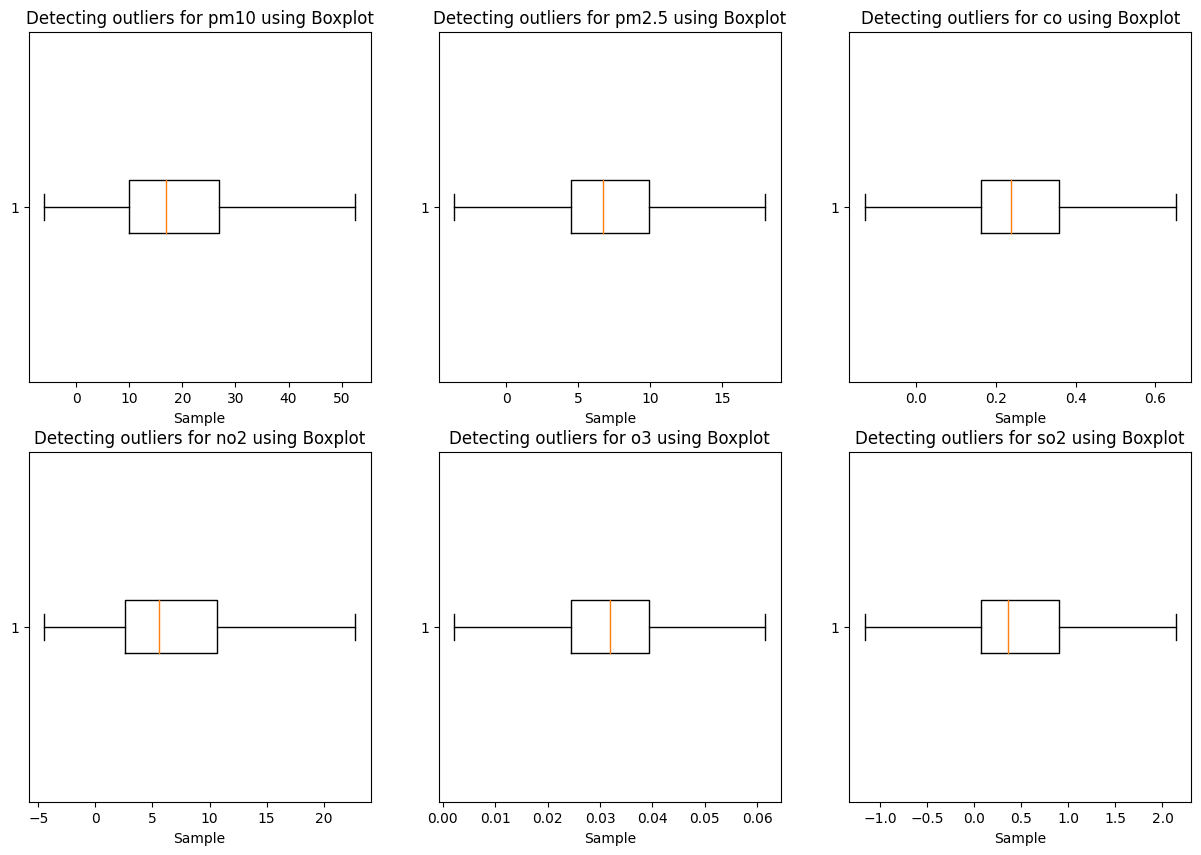

In [17]:
fig = plt.figure(figsize = (15, 10))

plt.subplot(2,3, 1)
plt.boxplot(pm10_df['pm10_mean'], vert=False)
plt.title("Detecting outliers for pm10 using Boxplot")
plt.xlabel('Sample')


plt.subplot(2,3,2)
plt.boxplot(pm2_df['pm25_mean'], vert=False)
plt.title("Detecting outliers for pm2.5 using Boxplot")
plt.xlabel('Sample')



plt.subplot(2,3,3)
plt.boxplot(co_df['co_mean'], vert=False)
plt.title("Detecting outliers for co using Boxplot")
plt.xlabel('Sample')


plt.subplot(2,3,4)
plt.boxplot(no2_df['no2_mean'], vert=False)
plt.title("Detecting outliers for no2 using Boxplot")
plt.xlabel('Sample')


plt.subplot(2,3,5)
plt.boxplot(ozone_df['o3_mean'], vert=False)
plt.title("Detecting outliers for o3 using Boxplot")
plt.xlabel('Sample')


plt.subplot(2,3,6)
plt.boxplot(so2_df['so2_mean'], vert=False)
plt.title("Detecting outliers for so2 using Boxplot")
plt.xlabel('Sample')
plt.show()

#### Grouping the data by Date and State wise to get the state wise results

In [18]:
pm10_df = pm10_df.groupby(['Date','State Name']).mean().reset_index()
pm2_df = pm2_df.groupby(['Date','State Name']).mean().reset_index()
co_df = co_df.groupby(['Date','State Name']).mean().reset_index()
no2_df = no2_df.groupby(['Date','State Name']).mean().reset_index()
ozone_df = ozone_df.groupby(['Date','State Name']).mean().reset_index()
so2_df = so2_df.groupby(['Date','State Name']).mean().reset_index()

In [19]:
pm10_df.head()

,Date,State Name,pm10_mean
0,2020-01-01,Alabama,12.500000
1,2020-01-01,Alaska,9.000000
2,2020-01-01,Arizona,23.852941
3,2020-01-01,Arkansas,16.000000
4,2020-01-01,California,17.615385


In [20]:
# Removing spaces begining and end of the string and coverting it to title.
# pm10_df['County Name'] = pm10_df['County Name'].apply(lambda x : x.strip().title())
pm10_df['State Name'] = pm10_df['State Name'].apply(lambda x : x.strip().title())
pm10_df['Date'] = pm10_df['Date'].apply(lambda x : x.strip())

# pm2_df['County Name'] = pm2_df['County Name'].apply(lambda x : x.strip().title())
pm2_df['State Name'] = pm2_df['State Name'].apply(lambda x : x.strip().title())
pm2_df['Date'] = pm2_df['Date'].apply(lambda x : x.strip())

# co_df['County Name'] = co_df['County Name'].apply(lambda x : x.strip().title())
co_df['State Name'] = co_df['State Name'].apply(lambda x : x.strip().title())
co_df['Date'] = co_df['Date'].apply(lambda x : x.strip())

# no2_df['County Name'] = no2_df['County Name'].apply(lambda x : x.strip().title())
no2_df['State Name'] = no2_df['State Name'].apply(lambda x : x.strip().title())
no2_df['Date'] = no2_df['Date'].apply(lambda x : x.strip())

# ozone_df['County Name'] = ozone_df['County Name'].apply(lambda x : x.strip().title())
ozone_df['State Name'] = ozone_df['State Name'].apply(lambda x : x.strip().title())
ozone_df['Date'] = ozone_df['Date'].apply(lambda x : x.strip())

# so2_df['County Name'] = so2_df['County Name'].apply(lambda x : x.strip().title())
so2_df['State Name'] = so2_df['State Name'].apply(lambda x : x.strip().title())
so2_df['Date'] = so2_df['Date'].apply(lambda x : x.strip())

#### Checking and Droping duplicates

In [21]:
print(pm10_df.duplicated(subset=['Date','State Name']).value_counts(),'\n')
print(pm2_df.duplicated(subset=['Date','State Name']).value_counts(),'\n')
print(co_df.duplicated(subset=['Date','State Name']).value_counts(),'\n')
print(no2_df.duplicated(subset=['Date','State Name']).value_counts(),'\n')
print(ozone_df.duplicated(subset=['Date','State Name']).value_counts(),'\n')
print(so2_df.duplicated(subset=['Date','State Name']).value_counts(),'\n')

False    43353
dtype: int64 

False    50367
dtype: int64 

False    49334
dtype: int64 

False    46127
dtype: int64 

False    51074
dtype: int64 

False    50012
dtype: int64 



In [22]:
# Droping duplicate values 
pm10_df.drop_duplicates(subset=['Date','State Name'],inplace = True)
pm2_df.drop_duplicates(subset=['Date','State Name'],inplace = True)
co_df.drop_duplicates(subset=['Date','State Name'],inplace = True)
no2_df.drop_duplicates(subset=['Date','State Name'],inplace = True)
ozone_df.drop_duplicates(subset=['Date','State Name'],inplace = True)
so2_df.drop_duplicates(subset=['Date','State Name'],inplace = True)

In [23]:
pm10_df.shape,pm2_df.shape,co_df.shape,no2_df.shape,ozone_df.shape,so2_df.shape

((43353, 3), (50367, 3), (49334, 3), (46127, 3), (51074, 3), (50012, 3))

In [24]:
pm10_df.isna().sum()

Date          0
State Name    0
pm10_mean     0
dtype: int64

In [135]:
# merged_pm10_pm2 = pd.merge(pm10_df, pm2_df, on = ['Date','State Name','City Name','County Name'], how='inner')
# merged_co_no2 = pd.merge(co_df, no2_df, on = ['Date','State Name','City Name','County Name'], how='inner')
# merged_ozone_so2 = pd.merge(ozone_df, so2_df, on = ['Date','State Name','City Name','County Name'], how='inner')
# merged_pm10_pm2_ozone_so2 = pd.merge(merged_pm10_pm2, merged_ozone_so2, on = ['Date','State Name','City Name','County Name'], how='inner')
# merged_pm10_pm2_co_no2 = pd.merge(merged_pm10_pm2, merged_co_no2, on = ['Date','State Name','City Name','County Name'], how='inner')
# merged_pollutants = pd.merge(merged_pm10_pm2_co_no2, merged_ozone_so2, on = ['Date','State Name','City Name','County Name'], how='inner')


### Merging meteorogical features

In [136]:
%cd '/home/students/divenna/info_project/Datasets'

/home/students/divenna/info_project/Datasets


#### Reading CSV files

In [137]:
import pandas as pd
press_2020_df = pd.read_csv('meteorogical_features/daily_PRESS_2020.csv')
press_2021_df = pd.read_csv('meteorogical_features/daily_PRESS_2021.csv')
press_2022_df = pd.read_csv('meteorogical_features/daily_PRESS_2022.csv')

In [138]:
rh_2020_df = pd.read_csv('meteorogical_features/daily_RH_DP_2020.csv')
rh_2021_df = pd.read_csv('meteorogical_features/daily_RH_DP_2021.csv')
rh_2022_df = pd.read_csv('meteorogical_features/daily_RH_DP_2022.csv')

In [139]:
temp_2020_df = pd.read_csv('meteorogical_features/daily_TEMP_2020.csv')
temp_2021_df = pd.read_csv('meteorogical_features/daily_TEMP_2021.csv')
temp_2022_df = pd.read_csv('meteorogical_features/daily_TEMP_2022.csv')

In [140]:
wind_2020_df = pd.read_csv('meteorogical_features/daily_WIND_2020.csv')
wind_2021_df = pd.read_csv('meteorogical_features/daily_WIND_2021.csv')
wind_2022_df = pd.read_csv('meteorogical_features/daily_WIND_2022.csv')

In [141]:
wind_2020_df.columns

Index(['State Code', 'County Code', 'Site Num', 'Parameter Code', 'POC',
       'Latitude', 'Longitude', 'Datum', 'Parameter Name', 'Sample Duration',
       'Pollutant Standard', 'Date Local', 'Units of Measure', 'Event Type',
       'Observation Count', 'Observation Percent', 'Arithmetic Mean',
       '1st Max Value', '1st Max Hour', 'AQI', 'Method Code', 'Method Name',
       'Local Site Name', 'Address', 'State Name', 'County Name', 'City Name',
       'CBSA Name', 'Date of Last Change'],
      dtype='object')

#### Feature selection or Removing Irrelevant Data

In [142]:
press_2020 = press_2020_df[['Date Local','State Name','Arithmetic Mean']]
press_2021 = press_2021_df[['Date Local','State Name','Arithmetic Mean']]
press_2022 = press_2022_df[['Date Local','State Name','Arithmetic Mean']]
rh_2020 = rh_2020_df[['Date Local','State Name','Arithmetic Mean']]
rh_2021 = rh_2021_df[['Date Local','State Name','Arithmetic Mean']]
rh_2022 = rh_2022_df[['Date Local','State Name','Arithmetic Mean']]
temp_2020 = temp_2020_df[['Date Local','State Name','Arithmetic Mean']]
temp_2021 = temp_2021_df[['Date Local','State Name','Arithmetic Mean']]
temp_2022 = temp_2022_df[['Date Local','State Name','Arithmetic Mean']]
wind_2020 = wind_2020_df[['Date Local','State Name','Arithmetic Mean']]
wind_2021 = wind_2021_df[['Date Local','State Name','Arithmetic Mean']]
wind_2022 = wind_2022_df[['Date Local','State Name','Arithmetic Mean']]

#### Concatenating the Dataframes along axis =0 (row)

In [143]:
press_df = pd.concat([press_2020,press_2021,press_2022],axis=0,ignore_index = True)
rh_df = pd.concat([rh_2020,rh_2021,rh_2022],axis=0,ignore_index = True)
temp_df = pd.concat([temp_2020,temp_2021,temp_2022],axis=0,ignore_index = True)
wind_df = pd.concat([wind_2020,wind_2021,wind_2022],axis=0,ignore_index = True)

#### Renaming Columns in a Dataframe

In [144]:
press_df.rename(columns = {'Arithmetic Mean':'press_mean','Date Local':'Date'}, inplace = True)
rh_df.rename(columns = {'Arithmetic Mean':'rh_mean','Date Local':'Date'}, inplace = True)
temp_df.rename(columns = {'Arithmetic Mean':'temp_mean','Date Local':'Date'}, inplace = True)
wind_df.rename(columns = {'Arithmetic Mean':'wind_mean','Date Local':'Date'}, inplace = True)

#### Outliers detection and Handling

##### Outlier detection through box plot

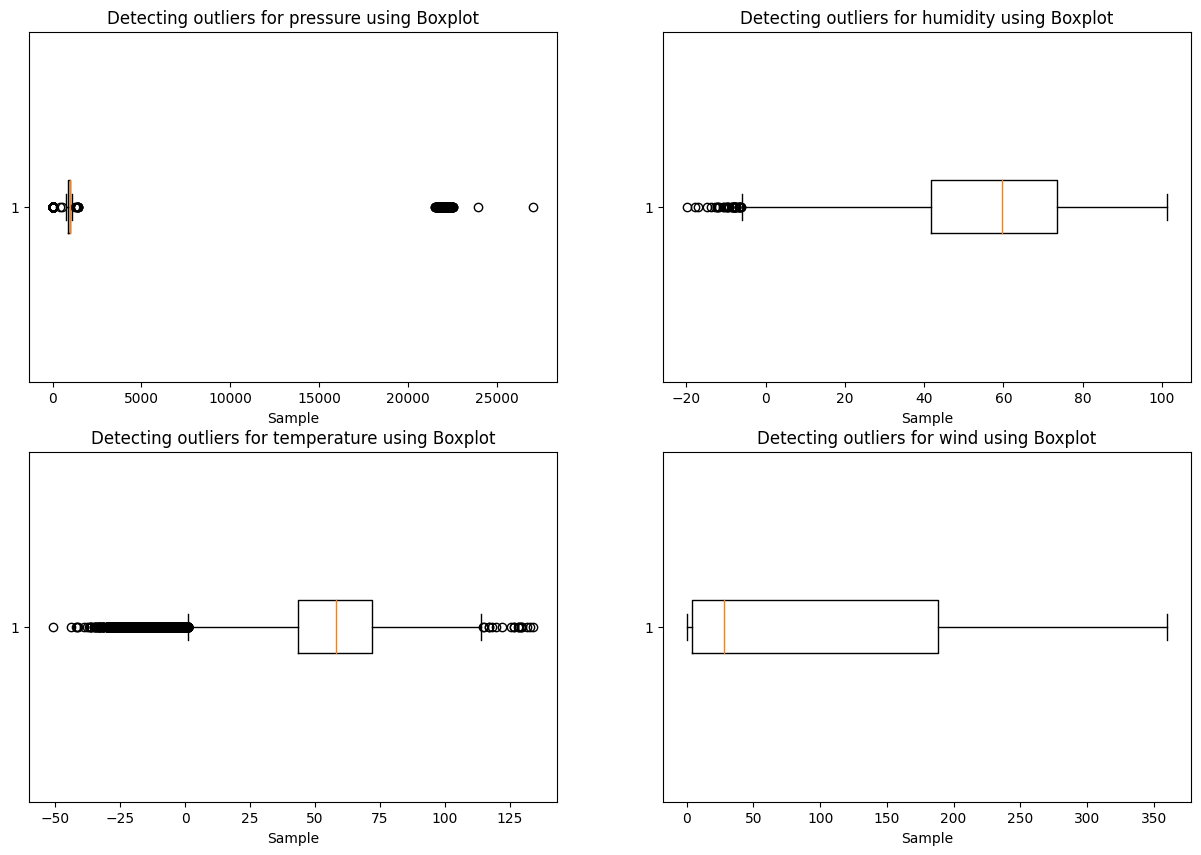

In [145]:
fig = plt.figure(figsize = (15, 10))

plt.subplot(2,2, 1)
plt.boxplot(press_df['press_mean'], vert=False)
plt.title("Detecting outliers for pressure using Boxplot")
plt.xlabel('Sample')

plt.subplot(2,2,2)
plt.boxplot(rh_df['rh_mean'], vert=False)
plt.title("Detecting outliers for humidity using Boxplot")
plt.xlabel('Sample')

plt.subplot(2,2,3)
plt.boxplot(temp_df['temp_mean'], vert=False)
plt.title("Detecting outliers for temperature using Boxplot")
plt.xlabel('Sample')

plt.subplot(2,2,4)
plt.boxplot(wind_df['wind_mean'], vert=False)
plt.title("Detecting outliers for wind using Boxplot")
plt.xlabel('Sample')

plt.show()

From this visualization, we can see the outliers

#### Outlier detection using Inter Quantile Range(IQR)

In [146]:
def detect_outliers_iqr(data):
    outliers = []
    data = sorted(data)
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    # print(q1, q3)
    IQR = q3-q1
    lwr_bound = q1-(1.5*IQR)
    upr_bound = q3+(1.5*IQR)
    # print(lwr_bound, upr_bound)
    for i in data: 
        if (i<lwr_bound or i>upr_bound):
            outliers.append(i)
    return outliers

sample_outliers = detect_outliers_iqr(press_df['press_mean'])
print("Outliers for Pressure from IQR method in percentage: ", (len(sample_outliers)/press_df.shape[0])*100)
sample_outliers = detect_outliers_iqr(rh_df['rh_mean'])
print("Outliers for humidity from IQR method in percentage: ", (len(sample_outliers)/rh_df.shape[0])*100)
sample_outliers = detect_outliers_iqr(temp_df['temp_mean'])
print("Outliers for Temperature from IQR method in percentage: ", (len(sample_outliers)/temp_df.shape[0])*100)
sample_outliers = detect_outliers_iqr(wind_df['wind_mean'])
print("Outliers for Wind from IQR method in percentage: ", (len(sample_outliers)/wind_df.shape[0])*100)

Outliers for Pressure from IQR method in percentage:  0.8337783202380045
Outliers for humidity from IQR method in percentage:  0.009390089008159493
Outliers for Temperature from IQR method in percentage:  0.4600547924304162
Outliers for Wind from IQR method in percentage:  0.0


#### Handling Outliers using Flooring and Capping

In [147]:
import pandas as pd
def flooring_capping(series):
    original_data = series
    sorted_data = sorted(series)
    q1 = np.percentile(sorted_data, 25)
    q3 = np.percentile(sorted_data, 75)
    # print(q1, q3)
    IQR = q3-q1
    lwr_bound = q1-(1.5*IQR)
    upr_bound = q3+(1.5*IQR)
    print(lwr_bound, upr_bound)
    corrected_list = []
    for i in original_data: 
        if i<lwr_bound:
            corrected_list.append(lwr_bound)
        elif i>upr_bound:
            corrected_list.append(upr_bound)
        else:
            corrected_list.append(i)
    return pd.Series(corrected_list)

press_df['press_mean'] = flooring_capping(press_df['press_mean'])
rh_df['rh_mean'] = flooring_capping(rh_df['rh_mean'])
temp_df['temp_mean'] = flooring_capping(temp_df['temp_mean'])
wind_df['wind_mean'] = flooring_capping(wind_df['wind_mean'])

703.6499994999999 1182.9166675000001
-6.1666674999999955 121.5000005
1.0625 114.5625
-272.7583325 464.7749995


#### Check for outliers after handling it

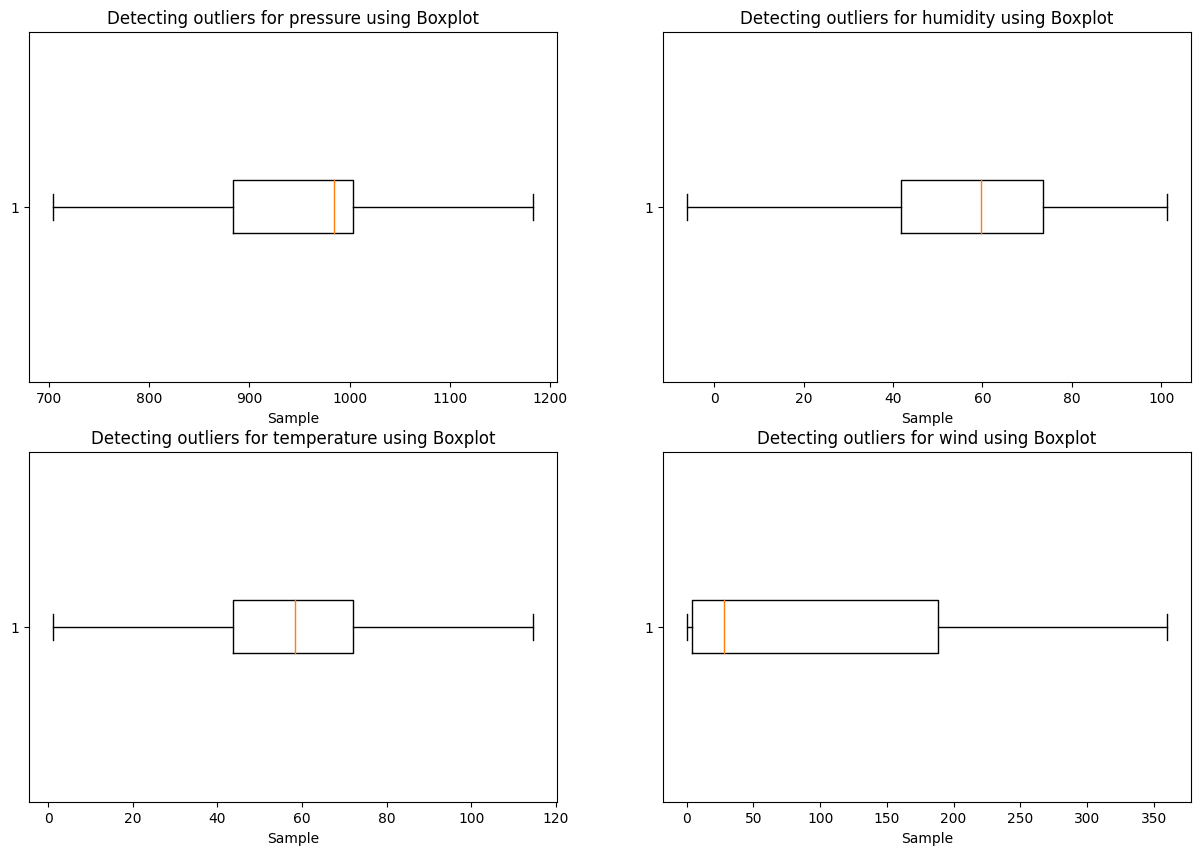

In [148]:
fig = plt.figure(figsize = (15, 10))

plt.subplot(2,2, 1)
plt.boxplot(press_df['press_mean'], vert=False)
plt.title("Detecting outliers for pressure using Boxplot")
plt.xlabel('Sample')

plt.subplot(2,2,2)
plt.boxplot(rh_df['rh_mean'], vert=False)
plt.title("Detecting outliers for humidity using Boxplot")
plt.xlabel('Sample')

plt.subplot(2,2,3)
plt.boxplot(temp_df['temp_mean'], vert=False)
plt.title("Detecting outliers for temperature using Boxplot")
plt.xlabel('Sample')

plt.subplot(2,2,4)
plt.boxplot(wind_df['wind_mean'], vert=False)
plt.title("Detecting outliers for wind using Boxplot")
plt.xlabel('Sample')

plt.show()

#### Grouping the data by Date and State Name wise

In [149]:
press_df = press_df.groupby(['Date','State Name']).mean().reset_index()
rh_df = rh_df.groupby(['Date','State Name']).mean().reset_index()
temp_df = temp_df.groupby(['Date','State Name']).mean().reset_index()
wind_df = wind_df.groupby(['Date','State Name']).mean().reset_index()

In [150]:
press_df.head()

,Date,State Name,press_mean
0,2020-01-01,Alabama,1000.610834
1,2020-01-01,Alaska,971.179167
2,2020-01-01,California,973.469771
3,2020-01-01,Colorado,814.807500
4,2020-01-01,Connecticut,991.923611


In [151]:
# Removing spaces begining and end of the string and coverting it to title.
# press_df['County Name'] = press_df['County Name'].apply(lambda x : x.strip().title())
press_df['State Name'] = press_df['State Name'].apply(lambda x : x.strip().title())
press_df['Date'] = press_df['Date'].apply(lambda x : x.strip())

# rh_df['County Name'] = pm2_df['County Name'].apply(lambda x : x.strip().title())
rh_df['State Name'] = rh_df['State Name'].apply(lambda x : x.strip().title())
rh_df['Date'] = rh_df['Date'].apply(lambda x : x.strip())

# temp_df['County Name'] = temp_df['County Name'].apply(lambda x : x.strip().title())
temp_df['State Name'] = temp_df['State Name'].apply(lambda x : x.strip().title())
temp_df['Date'] = temp_df['Date'].apply(lambda x : x.strip())

# wind_df['County Name'] = wind_df['County Name'].apply(lambda x : x.strip().title())
wind_df['State Name'] = wind_df['State Name'].apply(lambda x : x.strip().title())
wind_df['Date'] = wind_df['Date'].apply(lambda x : x.strip())

#### Checking and Droping duplicates

In [152]:
# Checking duplicates on certain columns
print(press_df.duplicated(subset=['Date','State Name']).value_counts(),'\n')
print(rh_df.duplicated(subset=['Date','State Name']).value_counts(),'\n')
print(temp_df.duplicated(subset=['Date','State Name']).value_counts(),'\n')
print(wind_df.duplicated(subset=['Date','State Name']).value_counts(),'\n')

False    36051
dtype: int64 

False    47142
dtype: int64 

False    47986
dtype: int64 

False    46616
dtype: int64 



In [153]:
# Droping duplicate values 
press_df.drop_duplicates(subset=['Date','State Name'],inplace = True)
rh_df.drop_duplicates(subset=['Date','State Name'],inplace = True)
temp_df.drop_duplicates(subset=['Date','State Name'],inplace = True)
wind_df.drop_duplicates(subset=['Date','State Name'],inplace = True)

In [154]:
# merged_press_rh = pd.merge(press_df, rh_df, on = ['Date Local','State Name','County Name'], how='inner')
# merged_temp_wind = pd.merge(temp_df, wind_df, on = ['Date Local','State Name','County Name'], how='inner')
# merged_meteorogical = pd.merge(merged_press_rh,merged_temp_wind, on = ['Date Local','State Name','County Name'], how='inner')

### Trips dataset cleaning

#### Reading CSV file

In [25]:
import pandas as pd
trips_df = pd.read_csv('trips/Trips_by_Distance.csv')

In [26]:
trips_df.head()

,Level,Date,State FIPS,State Postal Code,County FIPS,County Name,Population Staying at Home,Population Not Staying at Home,Number of Trips,Number of Trips <1,...,Number of Trips 5-10,Number of Trips 10-25,Number of Trips 25-50,Number of Trips 50-100,Number of Trips 100-250,Number of Trips 250-500,Number of Trips >=500,Row ID,Week,Month
0,National,2019/01/01,NaN,NaN,NaN,NaN,77433867.0,248733553.0,8.977844e+08,241667151.0,...,129670778.0,116904343.0,40432062.0,15686639.0,7525563.0,1806022.0,1728112.0,00-00000-20190101,0,1
1,National,2019/01/02,NaN,NaN,NaN,NaN,61305201.0,264862219.0,1.139452e+09,291276735.0,...,171637514.0,167412698.0,56148976.0,17739183.0,7817044.0,1962301.0,1531219.0,00-00000-20190102,0,1
2,National,2019/01/03,NaN,NaN,NaN,NaN,63050480.0,263116940.0,1.162753e+09,296375014.0,...,175775410.0,172027487.0,57632422.0,18366626.0,8124548.0,2038099.0,1567072.0,00-00000-20190103,0,1
3,National,2019/01/04,NaN,NaN,NaN,NaN,61803652.0,264363768.0,1.181954e+09,293159631.0,...,181324645.0,176144493.0,58761592.0,19315785.0,8687318.0,2096065.0,1569185.0,00-00000-20190104,0,1
4,National,2019/01/05,NaN,NaN,NaN,NaN,64389745.0,261777675.0,1.180477e+09,295459014.0,...,180941769.0,165239790.0,54842134.0,19363939.0,8490791.0,1991159.0,1438664.0,00-00000-20190105,0,1


In [27]:
trips_modified_df = trips_df[(trips_df['Date']>='2020/01/01')&(trips_df['Level']=='County')]
trips_modified_df.head()

,Level,Date,State FIPS,State Postal Code,County FIPS,County Name,Population Staying at Home,Population Not Staying at Home,Number of Trips,Number of Trips <1,...,Number of Trips 5-10,Number of Trips 10-25,Number of Trips 25-50,Number of Trips 50-100,Number of Trips 100-250,Number of Trips 250-500,Number of Trips >=500,Row ID,Week,Month
21061,County,2021/06/06,56.0,WY,56045.0,Weston County,1268.0,5659.0,22471.0,4160.0,...,1558.0,5723.0,2202.0,3930.0,1160.0,166.0,23.0,56-56045-20210606,23,6
22762,County,2021/06/06,5.0,AR,5011.0,Bradley County,1780.0,8983.0,25022.0,3411.0,...,4321.0,3343.0,1793.0,1383.0,690.0,35.0,0.0,05-05011-20210606,23,6
22763,County,2021/06/06,5.0,AR,5013.0,Calhoun County,571.0,4618.0,17543.0,2166.0,...,3600.0,4277.0,1141.0,530.0,425.0,41.0,0.0,05-05013-20210606,23,6
22764,County,2021/06/06,5.0,AR,5015.0,Carroll County,4386.0,23994.0,77047.0,14712.0,...,13170.0,14712.0,4272.0,1227.0,1323.0,132.0,36.0,05-05015-20210606,23,6
22765,County,2021/06/06,5.0,AR,5017.0,Chicot County,1356.0,8762.0,31550.0,9483.0,...,3929.0,3857.0,1380.0,580.0,957.0,61.0,4.0,05-05017-20210606,23,6


In [28]:
trips_modified_df['Date'].min(),trips_modified_df['Date'].max()

('2020/01/01', '2022/02/05')

In [29]:
trips_modified_df.shape

(2409914, 22)

#### Feature Selection or Removing Irrelevant Data

In [30]:
trips_modified_df = trips_modified_df[['Date','State Postal Code','Population Staying at Home','Population Not Staying at Home', 'Number of Trips']]

#### Renaming Columns

In [31]:
trips_modified_df.rename(columns = {'State Postal Code':'State Name'}, inplace = True)
trips_modified_df.head()

,Date,State Name,Population Staying at Home,Population Not Staying at Home,Number of Trips
21061,2021/06/06,WY,1268.0,5659.0,22471.0
22762,2021/06/06,AR,1780.0,8983.0,25022.0
22763,2021/06/06,AR,571.0,4618.0,17543.0
22764,2021/06/06,AR,4386.0,23994.0,77047.0
22765,2021/06/06,AR,1356.0,8762.0,31550.0


#### Replacing State Codes with their Names

In [32]:
state_code_name_df = pd.read_csv('air_pollution_base/state_code_name.csv')
state_code_name_df.head()

,State Code,State Name
0,AA,Armed Forces America
1,AE,Armed Forces
2,AK,Alaska
3,AL,Alabama
4,AP,Armed Forces Pacific


In [33]:
# Assigning State Code and its name to a Dictionary
code_name = {}
for code,name in zip(state_code_name_df['State Code'],state_code_name_df['State Name']):
    code_name[code]=name.strip()
    
code_name['DC']='Washington DC'

In [34]:
trips_modified_df['State Name'] = trips_modified_df['State Name'].apply(lambda x : code_name[x])

In [35]:
trips_modified_df.head()

,Date,State Name,Population Staying at Home,Population Not Staying at Home,Number of Trips
21061,2021/06/06,Wyoming,1268.0,5659.0,22471.0
22762,2021/06/06,Arkansas,1780.0,8983.0,25022.0
22763,2021/06/06,Arkansas,571.0,4618.0,17543.0
22764,2021/06/06,Arkansas,4386.0,23994.0,77047.0
22765,2021/06/06,Arkansas,1356.0,8762.0,31550.0


#### Checking for null values

In [36]:
trips_modified_df.shape

(2409914, 5)

#### Droping duplicate values

In [38]:
trips_modified_df.dropna(inplace=True)

In [39]:
trips_modified_df.shape

(2398466, 5)

In [40]:
trips_modified_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2398466 entries, 21061 to 3615243
Data columns (total 5 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   Date                            object 
 1   State Name                      object 
 2   Population Staying at Home      float64
 3   Population Not Staying at Home  float64
 4   Number of Trips                 float64
dtypes: float64(3), object(2)
memory usage: 109.8+ MB


#### Checking and handling outliers
##### Outlier detection through box plot

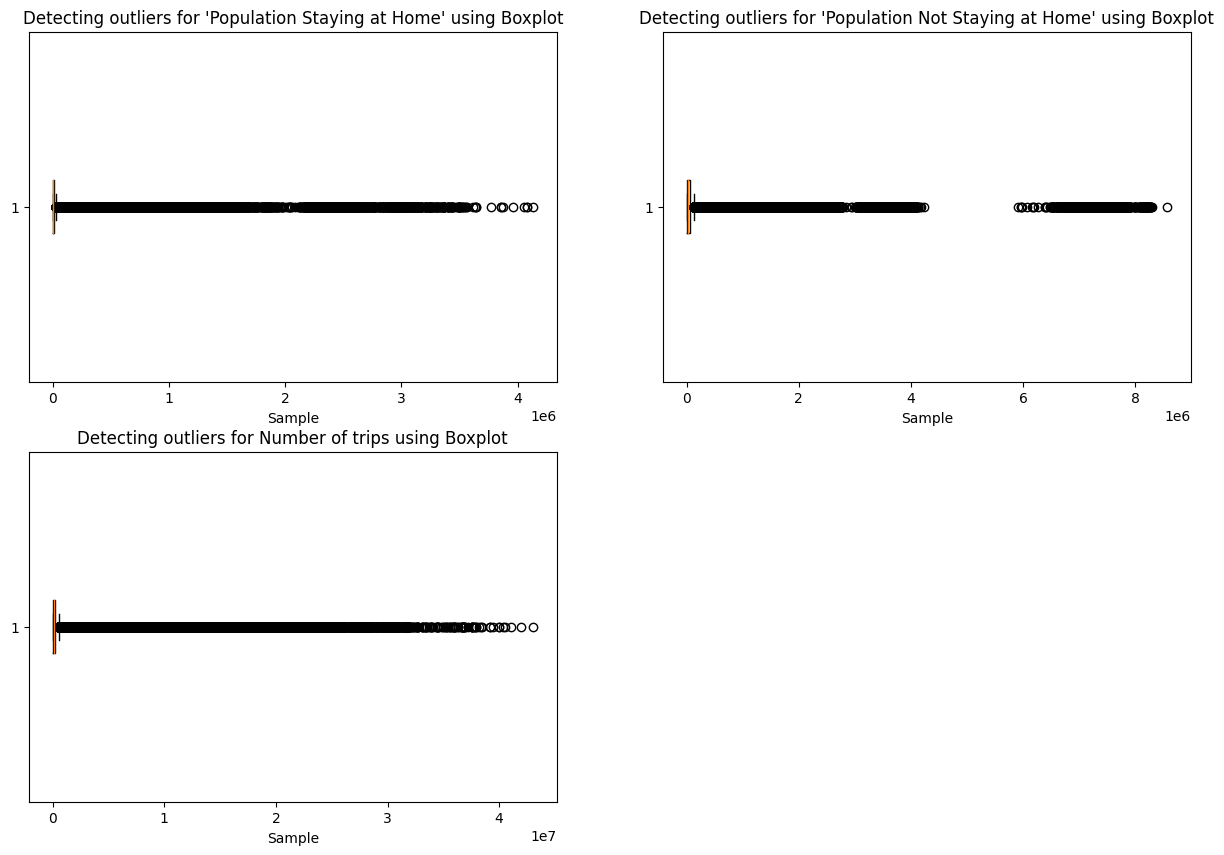

In [41]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize = (15, 10))

plt.subplot(2,2,1)
plt.boxplot(trips_modified_df['Population Staying at Home'], vert=False)
plt.title("Detecting outliers for 'Population Staying at Home' using Boxplot")
plt.xlabel('Sample')

plt.subplot(2,2,2)
plt.boxplot(trips_modified_df['Population Not Staying at Home'], vert=False)
plt.title("Detecting outliers for 'Population Not Staying at Home' using Boxplot")
plt.xlabel('Sample')

plt.subplot(2,2,3)
plt.boxplot(trips_modified_df['Number of Trips'], vert=False)
plt.title("Detecting outliers for Number of trips using Boxplot")
plt.xlabel('Sample')
plt.show()

There are outliers detected through Box plot

#### Outlier detection using Inter Quantile Range(IQR)

In [42]:
def detect_outliers_iqr(data):
    outliers = []
    data = sorted(data)
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    # print(q1, q3)
    IQR = q3-q1
    lwr_bound = q1-(1.5*IQR)
    upr_bound = q3+(1.5*IQR)
    # print(lwr_bound, upr_bound)
    for i in data: 
        if (i<lwr_bound or i>upr_bound):
            outliers.append(i)
    return outliers

sample_outliers = detect_outliers_iqr(trips_modified_df['Population Staying at Home'])
print("Outliers for 'Population Staying at Home' from IQR method in percentage: ", (len(sample_outliers)/trips_modified_df.shape[0])*100)

sample_outliers = detect_outliers_iqr(trips_modified_df['Population Not Staying at Home'])
print("Outliers for 'Population Not Staying at Home' from IQR method in percentage: ", (len(sample_outliers)/trips_modified_df.shape[0])*100)

sample_outliers = detect_outliers_iqr(trips_modified_df['Number of Trips'])
print("Outliers for 'Number of Trips' from IQR method in percentage: ", (len(sample_outliers)/trips_modified_df.shape[0])*100)

Outliers for 'Population Staying at Home' from IQR method in percentage:  13.8437234465696
Outliers for 'Population Not Staying at Home' from IQR method in percentage:  13.458852449857533
Outliers for 'Number of Trips' from IQR method in percentage:  13.070687681209572


#### Checking for Null Values

In [43]:
trips_modified_df.isna().sum()

Date                              0
State Name                        0
Population Staying at Home        0
Population Not Staying at Home    0
Number of Trips                   0
dtype: int64

In [44]:
trips_modified_df.reset_index(inplace=True)

In [45]:
trips_modified_df.head()

,index,Date,State Name,Population Staying at Home,Population Not Staying at Home,Number of Trips
0,21061,2021/06/06,Wyoming,1268.0,5659.0,22471.0
1,22762,2021/06/06,Arkansas,1780.0,8983.0,25022.0
2,22763,2021/06/06,Arkansas,571.0,4618.0,17543.0
3,22764,2021/06/06,Arkansas,4386.0,23994.0,77047.0
4,22765,2021/06/06,Arkansas,1356.0,8762.0,31550.0


In [46]:
trips_modified_df.columns

Index(['index', 'Date', 'State Name', 'Population Staying at Home',
       'Population Not Staying at Home', 'Number of Trips'],
      dtype='object')

In [47]:
trips_modified_df.drop(columns=['index'],inplace=True)

In [48]:
trips_modified_df.head()

,Date,State Name,Population Staying at Home,Population Not Staying at Home,Number of Trips
0,2021/06/06,Wyoming,1268.0,5659.0,22471.0
1,2021/06/06,Arkansas,1780.0,8983.0,25022.0
2,2021/06/06,Arkansas,571.0,4618.0,17543.0
3,2021/06/06,Arkansas,4386.0,23994.0,77047.0
4,2021/06/06,Arkansas,1356.0,8762.0,31550.0


In [49]:
trips_modified_df['Population Not Staying at Home'].isna().sum()

0

In [50]:
trips_modified_df['Population Not Staying at Home'].shape

(2398466,)

#### Handling Outliers

##### Handling outliers through Quantile based flooring and capping

In [181]:
import pandas as pd

def flooring_capping(i):
    if i<lwr_bound:
        return lwr_bound
    elif i>upr_bound:
        return upr_bound
    else:
        return i



In [182]:
def get_lwr_upr(series):
    sorted_data = sorted(series)
    q1 = np.percentile(sorted_data, 25)
    q3 = np.percentile(sorted_data, 75)
    # print(q1, q3)
    IQR = q3-q1
    lwr_bound = q1-(1.5*IQR)
    upr_bound = q3+(1.5*IQR)
    return lwr_bound,upr_bound

In [183]:
lwr_bound,upr_bound = get_lwr_upr(trips_modified_df['Population Staying at Home'])
trips_modified_df['Population Staying at Home']=trips_modified_df['Population Staying at Home'].apply(flooring_capping)

lwr_bound,upr_bound = get_lwr_upr(trips_modified_df['Population Not Staying at Home'])
trips_modified_df['Population Not Staying at Home']=trips_modified_df['Population Not Staying at Home'].apply(flooring_capping)

lwr_bound,upr_bound = get_lwr_upr(trips_modified_df['Number of Trips'])
trips_modified_df['Number of Trips']=trips_modified_df['Number of Trips'].apply(flooring_capping)


In [184]:
trips_modified_df['Population Not Staying at Home'].shape

(2398466,)

In [185]:
trips_modified_df.tail()

,Date,State Name,Population Staying at Home,Population Not Staying at Home,Number of Trips
2398461,2022/02/05,Alabama,1946.0,15259.0,69069.000
2398462,2022/02/05,Alabama,18024.0,87858.0,369592.000
2398463,2022/02/05,Alabama,7857.0,43769.0,186441.000
2398464,2022/02/05,Alabama,31912.0,124026.0,558057.375
2398465,2022/02/05,Alabama,2008.0,11797.0,51939.000


In [186]:
trips_modified_df.isna().sum()

Date                              0
State Name                        0
Population Staying at Home        0
Population Not Staying at Home    0
Number of Trips                   0
dtype: int64

#### Checking for outliers after handling it

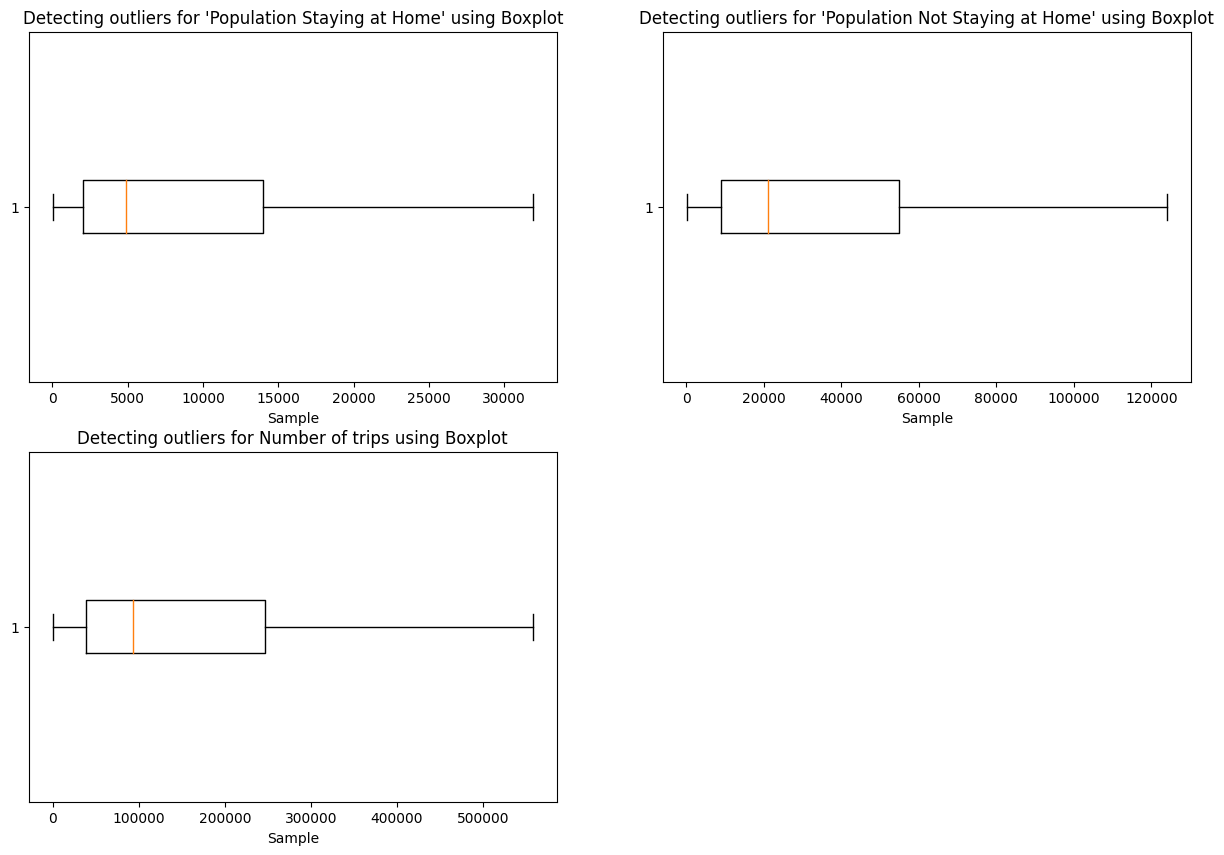

In [187]:
fig = plt.figure(figsize = (15, 10))

plt.subplot(2,2, 1)
plt.boxplot(trips_modified_df['Population Staying at Home'], vert=False)
plt.title("Detecting outliers for 'Population Staying at Home' using Boxplot")
plt.xlabel('Sample')

plt.subplot(2,2,2)
plt.boxplot(trips_modified_df['Population Not Staying at Home'], vert=False)
plt.title("Detecting outliers for 'Population Not Staying at Home' using Boxplot")
plt.xlabel('Sample')

plt.subplot(2,2,3)
plt.boxplot(trips_modified_df['Number of Trips'], vert=False)
plt.title("Detecting outliers for Number of trips using Boxplot")
plt.xlabel('Sample')

plt.show()

#### Removing spaces begining and end of the string and coverting it to title.

In [188]:
trips_modified_df['State Name'] = trips_modified_df['State Name'].apply(lambda x : x.strip().title())
trips_modified_df['Date'] = trips_modified_df['Date'].apply(lambda x : x.replace('/','-'))
trips_modified_df.head()

,Date,State Name,Population Staying at Home,Population Not Staying at Home,Number of Trips
0,2021-06-06,Wyoming,1268.0,5659.0,22471.0
1,2021-06-06,Arkansas,1780.0,8983.0,25022.0
2,2021-06-06,Arkansas,571.0,4618.0,17543.0
3,2021-06-06,Arkansas,4386.0,23994.0,77047.0
4,2021-06-06,Arkansas,1356.0,8762.0,31550.0


#### Grouping by Date and State Name

In [189]:
trips_modified_df = trips_modified_df.groupby(['Date','State Name']).sum().reset_index()

#### Checking and Droping Duplicates

In [190]:
# Checking duplicates on certain columns
print(trips_modified_df.duplicated(subset=['Date','State Name']).value_counts(),'\n')

False    39117
dtype: int64 



In [191]:
trips_modified_df.shape

(39117, 5)

In [192]:
# droping duplicates
trips_modified_df.drop_duplicates(subset=['Date','State Name'],inplace = True)

In [193]:
trips_modified_df.shape

(39117, 5)

### Covid-19 Dataset Cleaning

#### Read CSV files

In [1]:
import pandas as pd
covid_19_df = pd.read_csv('covid_19/us-states.csv')
covid_19_df.head()

,date,state,fips,cases,deaths
0,2020-01-21,Washington,53,1,0
1,2020-01-22,Washington,53,1,0
2,2020-01-23,Washington,53,1,0
3,2020-01-24,Illinois,17,1,0
4,2020-01-24,Washington,53,1,0


In [2]:
covid_19_df.tail()

,date,state,fips,cases,deaths
55441,2022-11-27,Virginia,51,2143804,22495
55442,2022-11-27,Washington,53,1854190,14775
55443,2022-11-27,West Virginia,54,613165,7714
55444,2022-11-27,Wisconsin,55,1921427,15651
55445,2022-11-27,Wyoming,56,180426,1931


In [3]:
covid_19_df.isna().sum()

date      0
state     0
fips      0
cases     0
deaths    0
dtype: int64

In [4]:
covid_19_df.loc[55396,'cases']

1707268

In [5]:
import numpy as np
columns_list = list(covid_19_df['state'].unique())
covid_grp_df=covid_19_df.groupby(['state'])
grp_df = []
covid_19_df['new cases']=covid_19_df['cases']
for col_name in columns_list:
    state_grp_df = covid_grp_df.get_group(col_name).reset_index()
    state_grp_df = state_grp_df.sort_values(by='date', ascending=True)
    prev_val = 0
    for i in range(state_grp_df.shape[0]):
        if i>0:
            prev_val = state_grp_df.loc[i-1,'cases']
            if prev_val== state_grp_df.loc[i,'cases']:
                state_grp_df.loc[i,'new cases']=0
            elif state_grp_df.loc[i,'cases']>prev_val:
                state_grp_df.loc[i,'new cases'] = state_grp_df.loc[i,'cases']-prev_val
            else:
                state_grp_df.loc[i,'new cases'] = np.nan
    grp_df.append(state_grp_df)

covid_grp_merged_df = pd.concat(grp_df,axis = 0, ignore_index = True)

In [6]:
covid_grp_merged_df.isna().sum()

index         0
date          0
state         0
fips          0
cases         0
deaths        0
new cases    99
dtype: int64

In [7]:
covid_grp_merged_df.dropna(inplace=True)

In [8]:
covid_grp_merged_df.isna().sum()

index        0
date         0
state        0
fips         0
cases        0
deaths       0
new cases    0
dtype: int64

In [9]:
covid_grp_merged_df.head()

,index,date,state,fips,cases,deaths,new cases
0,0,2020-01-21,Washington,53,1,0,1.0
1,1,2020-01-22,Washington,53,1,0,0.0
2,2,2020-01-23,Washington,53,1,0,0.0
3,4,2020-01-24,Washington,53,1,0,0.0
4,7,2020-01-25,Washington,53,1,0,0.0


In [10]:
covid_19_modified_df=covid_grp_merged_df

In [11]:
covid_19_modified_df.rename(columns={'date':'Date','state':'State Name','new cases':'New Covid Cases'},inplace=True)

In [12]:
covid_19_modified_df.shape

(55347, 7)

In [13]:
covid_19_modified_df.head()

,index,Date,State Name,fips,cases,deaths,New Covid Cases
0,0,2020-01-21,Washington,53,1,0,1.0
1,1,2020-01-22,Washington,53,1,0,0.0
2,2,2020-01-23,Washington,53,1,0,0.0
3,4,2020-01-24,Washington,53,1,0,0.0
4,7,2020-01-25,Washington,53,1,0,0.0


#### Feature selection or Removing Irrelevant Data

In [14]:
covid_19_modified_df = covid_19_modified_df[['Date','State Name','New Covid Cases']]
covid_19_modified_df.isna().sum()

Date               0
State Name         0
New Covid Cases    0
dtype: int64

In [15]:
covid_19_modified_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55347 entries, 0 to 55445
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date             55347 non-null  object 
 1   State Name       55347 non-null  object 
 2   New Covid Cases  55347 non-null  float64
dtypes: float64(1), object(2)
memory usage: 1.7+ MB


In [16]:
covid_19_modified_df['New Covid Cases'].max(), covid_19_modified_df['New Covid Cases'].min()

(227972.0, 0.0)

#### Checking and handling Outliers

#### Outlier detection through box plot

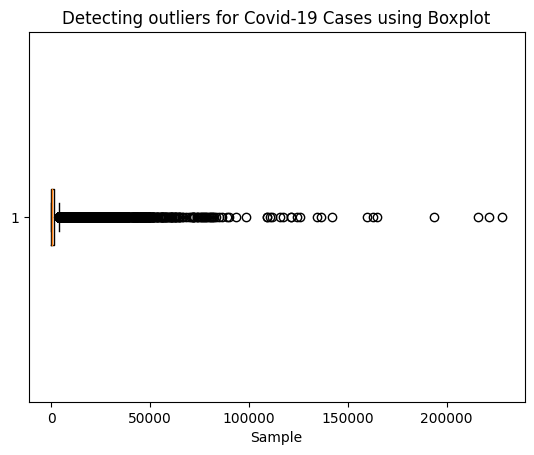

In [17]:
import numpy as np
import matplotlib.pyplot as plt


plt.boxplot(covid_19_modified_df['New Covid Cases'], vert=False)
plt.title("Detecting outliers for Covid-19 Cases using Boxplot")
plt.xlabel('Sample')
plt.show()

There are outliers present in the dataset

#### Detecting outliers using Inter Quatertile Range

In [18]:
def detect_outliers_iqr(data):
    outliers = []
    data = sorted(data)
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    # print(q1, q3)
    IQR = q3-q1
    lwr_bound = q1-(1.5*IQR)
    upr_bound = q3+(1.5*IQR)
    # print(lwr_bound, upr_bound)
    for i in data: 
        if (i<lwr_bound or i>upr_bound):
            outliers.append(i)
    return outliers


In [19]:
sample_outliers = detect_outliers_iqr(covid_19_modified_df['New Covid Cases'])
print("Outliers for 'Covid Cases' from IQR method in percentage: ", (len(sample_outliers)/covid_19_modified_df.shape[0])*100)

Outliers for 'Covid Cases' from IQR method in percentage:  11.541727645581513


#### Handling outliers using flooring and capping

In [20]:
import pandas as pd
def flooring_capping(series):
    original_data = series
    sorted_data = sorted(series)
    q1 = np.percentile(sorted_data, 25)
    q3 = np.percentile(sorted_data, 75)
    # print(q1, q3)
    IQR = q3-q1
    lwr_bound = q1-(1.5*IQR)
    upr_bound = q3+(1.5*IQR)
    print(lwr_bound, upr_bound)
    corrected_list = []
    for i in original_data: 
        if i<lwr_bound:
            corrected_list.append(lwr_bound)
        elif i>upr_bound:
            corrected_list.append(upr_bound)
        else:
            corrected_list.append(i)
    return pd.Series(corrected_list)


In [21]:
covid_19_modified_df['New Covid Cases'] = flooring_capping(covid_19_modified_df['New Covid Cases'])

-2235.0 3749.0


/tmp/ipykernel_898598/1647264601.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covid_19_modified_df['New Covid Cases'] = flooring_capping(covid_19_modified_df['New Covid Cases'])


In [22]:
covid_19_modified_df.isna().sum()

Date                0
State Name          0
New Covid Cases    99
dtype: int64

In [23]:
covid_19_modified_df.dropna(inplace=True)

/tmp/ipykernel_898598/2916229298.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covid_19_modified_df.dropna(inplace=True)


In [24]:
covid_19_modified_df.isna().sum()

Date               0
State Name         0
New Covid Cases    0
dtype: int64

#### Checking for outliers after handling it

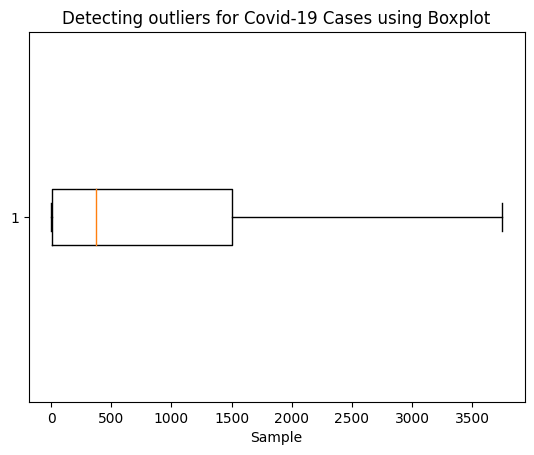

In [25]:
import numpy as np
import matplotlib.pyplot as plt


plt.boxplot(covid_19_modified_df['New Covid Cases'], vert=False)
plt.title("Detecting outliers for Covid-19 Cases using Boxplot")
plt.xlabel('Sample')
plt.show()

#### Renaming columns of a dataframe

In [26]:
covid_19_modified_df.head()

,Date,State Name,New Covid Cases
0,2020-01-21,Washington,1.0
1,2020-01-22,Washington,0.0
2,2020-01-23,Washington,0.0
3,2020-01-24,Washington,0.0
4,2020-01-25,Washington,0.0


#### Checking for Null Values

In [27]:
covid_19_modified_df.isna().sum()

Date               0
State Name         0
New Covid Cases    0
dtype: int64

#### Checking and Droping Duplicate values

In [28]:
covid_19_modified_df.duplicated(subset=['Date','State Name']).value_counts()

False    55248
dtype: int64

In [29]:
covid_19_modified_df.to_csv('covid_19_new_cases.csv',index=False)

In [30]:
pd.read_csv('covid_19_new_cases.csv').head()

,Date,State Name,New Covid Cases
0,2020-01-21,Washington,1.0
1,2020-01-22,Washington,0.0
2,2020-01-23,Washington,0.0
3,2020-01-24,Washington,0.0
4,2020-01-25,Washington,0.0


### Merging All pollutants, meteorological, trips and Covid-19 datasets on common column names

In [220]:
aqi_df.head()

,Date,State Name,AQI
0,2020-01-01,Alabama,36.666667
1,2020-01-01,Alaska,27.250000
2,2020-01-01,Arizona,43.307692
3,2020-01-01,Arkansas,35.454545
4,2020-01-01,California,55.358491


In [221]:
aqi_df.isna().sum()

Date          0
State Name    0
AQI           0
dtype: int64

In [222]:
pm10_df.head()

,Date,State Name,pm10_mean
0,2020-01-01,Alabama,12.500000
1,2020-01-01,Alaska,9.000000
2,2020-01-01,Arizona,23.852941
3,2020-01-01,Arkansas,16.000000
4,2020-01-01,California,17.615385


In [223]:
pm10_df.isna().sum()

Date          0
State Name    0
pm10_mean     0
dtype: int64

In [224]:
pm2_df.head()

,Date,State Name,pm25_mean
0,2020-01-01,Alabama,8.225962
1,2020-01-01,Alaska,9.400000
2,2020-01-01,Arizona,15.358824
3,2020-01-01,Arkansas,9.130000
4,2020-01-01,California,11.933323


In [225]:
pm2_df.isna().sum()

Date          0
State Name    0
pm25_mean     0
dtype: int64

In [226]:
co_df.head()

,Date,State Name,co_mean
0,2020-01-01,Alabama,0.295698
1,2020-01-01,Alaska,0.651145
2,2020-01-01,Arizona,0.509835
3,2020-01-01,Arkansas,0.541886
4,2020-01-01,California,0.408814


In [227]:
co_df.isna().sum()

Date          0
State Name    0
co_mean       0
dtype: int64

In [228]:
no2_df.head()

,Date,State Name,no2_mean
0,2020-01-01,Alabama,16.373918
1,2020-01-01,Arizona,15.102381
2,2020-01-01,Arkansas,10.906250
3,2020-01-01,California,10.150140
4,2020-01-01,Colorado,12.381218


In [229]:
no2_df.isna().sum()

Date          0
State Name    0
no2_mean      0
dtype: int64

In [230]:
ozone_df.head()

,Date,State Name,o3_mean
0,2020-01-01,Alabama,0.033676
1,2020-01-01,Alaska,0.031677
2,2020-01-01,Arizona,0.021959
3,2020-01-01,Arkansas,0.031213
4,2020-01-01,California,0.022262


In [231]:
so2_df.head()

,Date,State Name,so2_mean
0,2020-01-01,Alabama,0.905859
1,2020-01-01,Alaska,1.345833
2,2020-01-01,Arizona,1.253740
3,2020-01-01,Arkansas,0.837500
4,2020-01-01,California,0.570346


In [232]:
press_df.head()


,Date,State Name,press_mean
0,2020-01-01,Alabama,1000.610834
1,2020-01-01,Alaska,971.179167
2,2020-01-01,California,973.469771
3,2020-01-01,Colorado,814.807500
4,2020-01-01,Connecticut,991.923611


In [233]:
rh_df.head()

,Date,State Name,rh_mean
0,2020-01-01,Alabama,50.480556
1,2020-01-01,Alaska,79.000000
2,2020-01-01,Arizona,66.445833
3,2020-01-01,Arkansas,26.458333
4,2020-01-01,California,64.127964


In [234]:
temp_df.head()

,Date,State Name,temp_mean
0,2020-01-01,Alabama,48.435555
1,2020-01-01,Alaska,1.062500
2,2020-01-01,Arizona,43.815476
3,2020-01-01,Arkansas,43.375000
4,2020-01-01,California,49.710225


In [235]:
wind_df.head()

,Date,State Name,wind_mean
0,2020-01-01,Alabama,92.363889
1,2020-01-01,Alaska,102.472322
2,2020-01-01,Arizona,89.991429
3,2020-01-01,Arkansas,105.429167
4,2020-01-01,California,93.809963


In [236]:
trips_modified_df.head()

,Date,State Name,Population Staying at Home,Population Not Staying at Home,Number of Trips
0,2020-01-01,Alabama,739308.0,2925370.0,1.053467e+07
1,2020-01-01,Alaska,158094.0,438382.0,1.800841e+06
2,2020-01-01,Arizona,340556.0,1214548.0,4.949266e+06
3,2020-01-01,Arkansas,541026.0,2034160.0,7.096952e+06
4,2020-01-01,California,1348187.0,4991812.0,2.143521e+07


In [237]:
covid_19_modified_df.head()

,Date,State Name,New Covid Cases
0,2020-01-21,Washington,1.0
1,2020-01-22,Washington,0.0
2,2020-01-23,Washington,0.0
3,2020-01-24,Washington,0.0
4,2020-01-25,Washington,0.0


In [238]:
merged_pm10_pm2 = pd.merge(pm10_df, pm2_df, on = ['Date','State Name'], how='inner')
merged_co_no2 = pd.merge(co_df, no2_df, on = ['Date','State Name'], how='inner')
merged_ozone_so2 = pd.merge(ozone_df, so2_df, on = ['Date','State Name'], how='inner')
merged_pm10_pm2_co_no2 = pd.merge(merged_pm10_pm2, merged_co_no2, on = ['Date','State Name'], how='inner')
merged_pollutants = pd.merge(merged_pm10_pm2_co_no2, merged_ozone_so2, on = ['Date','State Name'], how='inner')

In [239]:
merged_pollutants.shape

(38082, 8)

In [240]:
merged_press_rh = pd.merge(press_df, rh_df, on = ['Date','State Name'], how='inner')
merged_temp_wind = pd.merge(temp_df, wind_df, on = ['Date','State Name'], how='inner')
merged_meteorogical = pd.merge(merged_press_rh,merged_temp_wind, on = ['Date','State Name'], how='inner')

In [241]:
merged_meteorogical.shape

(35146, 6)

In [242]:
merged_aqi_trips = pd.merge(aqi_df, trips_modified_df, on = ['Date','State Name'], how='inner')
merged_aqi_trips_pol = pd.merge(merged_aqi_trips, merged_pollutants, on = ['Date','State Name'], how='inner')
merged_aqi_trips_pol_meteo = pd.merge(merged_aqi_trips_pol, merged_meteorogical, on = ['Date','State Name'], how='inner')

In [243]:
merged_aqi_trips.shape,merged_aqi_trips_pol.shape,merged_aqi_trips_pol_meteo.shape

((38350, 6), (29885, 12), (23162, 16))

In [244]:
merged_aqi_trips_pol_meteo.shape

(23162, 16)

In [245]:
merged_aqi_trips_pol_meteo.head()

,Date,State Name,AQI,Population Staying at Home,Population Not Staying at Home,Number of Trips,pm10_mean,pm25_mean,co_mean,no2_mean,o3_mean,so2_mean,press_mean,rh_mean,temp_mean,wind_mean
0,2020-01-01,Alabama,36.666667,739308.0,2925370.0,1.053467e+07,12.500000,8.225962,0.295698,16.373918,0.033676,0.905859,1000.610834,50.480556,48.435555,92.363889
1,2020-01-01,California,55.358491,1348187.0,4991812.0,2.143521e+07,17.615385,11.933323,0.408814,10.150140,0.022262,0.570346,973.469771,64.127964,49.710225,93.809963
2,2020-01-01,Colorado,30.518519,586771.0,1985137.0,8.867251e+06,10.250000,4.785586,0.325372,12.381218,0.038290,1.102743,814.807500,65.336111,31.375000,113.998580
3,2020-01-01,Connecticut,22.166667,249491.0,951253.0,3.862218e+06,5.200000,3.106250,0.193428,6.553261,0.024059,0.105797,991.923611,46.104167,37.482143,135.210606
4,2020-01-01,Florida,46.051282,1347774.0,5176612.0,2.106439e+07,19.600000,13.366013,0.309174,11.087917,0.030658,1.020566,1017.479167,67.427084,61.408333,102.174306


In [246]:
all_merged_df = pd.merge(merged_aqi_trips_pol_meteo,covid_19_modified_df,on = ['Date','State Name'], how='left')

In [247]:
all_merged_df.shape

(23162, 17)

In [248]:
all_merged_df.head()

,Date,State Name,AQI,Population Staying at Home,Population Not Staying at Home,Number of Trips,pm10_mean,pm25_mean,co_mean,no2_mean,o3_mean,so2_mean,press_mean,rh_mean,temp_mean,wind_mean,New Covid Cases
0,2020-01-01,Alabama,36.666667,739308.0,2925370.0,1.053467e+07,12.500000,8.225962,0.295698,16.373918,0.033676,0.905859,1000.610834,50.480556,48.435555,92.363889,NaN
1,2020-01-01,California,55.358491,1348187.0,4991812.0,2.143521e+07,17.615385,11.933323,0.408814,10.150140,0.022262,0.570346,973.469771,64.127964,49.710225,93.809963,NaN
2,2020-01-01,Colorado,30.518519,586771.0,1985137.0,8.867251e+06,10.250000,4.785586,0.325372,12.381218,0.038290,1.102743,814.807500,65.336111,31.375000,113.998580,NaN
3,2020-01-01,Connecticut,22.166667,249491.0,951253.0,3.862218e+06,5.200000,3.106250,0.193428,6.553261,0.024059,0.105797,991.923611,46.104167,37.482143,135.210606,NaN
4,2020-01-01,Florida,46.051282,1347774.0,5176612.0,2.106439e+07,19.600000,13.366013,0.309174,11.087917,0.030658,1.020566,1017.479167,67.427084,61.408333,102.174306,NaN


In [249]:
all_merged_df.isna().sum()

Date                                 0
State Name                           0
AQI                                  0
Population Staying at Home           0
Population Not Staying at Home       0
Number of Trips                      0
pm10_mean                            0
pm25_mean                            0
co_mean                              0
no2_mean                             0
o3_mean                              0
so2_mean                             0
press_mean                           0
rh_mean                              0
temp_mean                            0
wind_mean                            0
New Covid Cases                   1813
dtype: int64

In [250]:
all_merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23162 entries, 0 to 23161
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Date                            23162 non-null  object 
 1   State Name                      23162 non-null  object 
 2   AQI                             23162 non-null  float64
 3   Population Staying at Home      23162 non-null  float64
 4   Population Not Staying at Home  23162 non-null  float64
 5   Number of Trips                 23162 non-null  float64
 6   pm10_mean                       23162 non-null  float64
 7   pm25_mean                       23162 non-null  float64
 8   co_mean                         23162 non-null  float64
 9   no2_mean                        23162 non-null  float64
 10  o3_mean                         23162 non-null  float64
 11  so2_mean                        23162 non-null  float64
 12  press_mean                      

In [251]:
all_merged_df['Category'] = all_merged_df['AQI']

In [252]:
import math
def label_aqi_values(x):
    x = math.floor(x)
    if x>=0 and x<=50:
        return 'Good'
    elif x>=51 and x<=100:
        return 'Moderate'
    elif x>=101 and x<=150:
        return 'Unhealthy for Sensitive Group'
    elif x>=151 and x<=200:
        return 'Unhealthy'
    elif x>=201 and x<=300:
        return 'Very Unhealthy'
    elif x>=301 and x<=500:
        return 'Hazardous'
        

In [253]:
all_merged_df['Category'] = all_merged_df['Category'].apply(label_aqi_values)

In [254]:
all_merged_df['Category'].value_counts()

Good        20555
Moderate     2607
Name: Category, dtype: int64

In [255]:
all_merged_df['Category'].isna().sum()

0

#### Arranging columns in right order

In [257]:
all_merged_df = all_merged_df[['Date', 'State Name','New Covid Cases','Population Staying at Home',
       'Population Not Staying at Home', 'Number of Trips', 'pm10_mean',
       'pm25_mean', 'co_mean', 'no2_mean', 'o3_mean', 'so2_mean', 'press_mean',
       'rh_mean', 'temp_mean', 'wind_mean', 'AQI','Category']]

In [258]:
all_merged_df.isna().sum()

Date                                 0
State Name                           0
New Covid Cases                   1813
Population Staying at Home           0
Population Not Staying at Home       0
Number of Trips                      0
pm10_mean                            0
pm25_mean                            0
co_mean                              0
no2_mean                             0
o3_mean                              0
so2_mean                             0
press_mean                           0
rh_mean                              0
temp_mean                            0
wind_mean                            0
AQI                                  0
Category                             0
dtype: int64

### Handling Null Values

In [260]:
all_merged_df['New Covid Cases'].fillna(0,inplace=True)

In [261]:
all_merged_df.isna().sum()

Date                              0
State Name                        0
New Covid Cases                   0
Population Staying at Home        0
Population Not Staying at Home    0
Number of Trips                   0
pm10_mean                         0
pm25_mean                         0
co_mean                           0
no2_mean                          0
o3_mean                           0
so2_mean                          0
press_mean                        0
rh_mean                           0
temp_mean                         0
wind_mean                         0
AQI                               0
Category                          0
dtype: int64

In [262]:
all_merged_df.to_csv('new_cases_covid_air_pollution.csv',index=False)

In [31]:
df = pd.read_csv('new_cases_covid_air_pollution.csv')

In [32]:
df.head()

,Date,State Name,New Covid Cases,Population Staying at Home,Population Not Staying at Home,Number of Trips,pm10_mean,pm25_mean,co_mean,no2_mean,o3_mean,so2_mean,press_mean,rh_mean,temp_mean,wind_mean,AQI,Category
0,2020-01-01,Alabama,0.0,739308.0,2925370.0,1.053467e+07,12.500000,8.225962,0.295698,16.373918,0.033676,0.905859,1000.610834,50.480556,48.435555,92.363889,36.666667,Good
1,2020-01-01,California,0.0,1348187.0,4991812.0,2.143521e+07,17.615385,11.933323,0.408814,10.150140,0.022262,0.570346,973.469771,64.127964,49.710225,93.809963,55.358491,Moderate
2,2020-01-01,Colorado,0.0,586771.0,1985137.0,8.867251e+06,10.250000,4.785586,0.325372,12.381218,0.038290,1.102743,814.807500,65.336111,31.375000,113.998580,30.518519,Good
3,2020-01-01,Connecticut,0.0,249491.0,951253.0,3.862218e+06,5.200000,3.106250,0.193428,6.553261,0.024059,0.105797,991.923611,46.104167,37.482143,135.210606,22.166667,Good
4,2020-01-01,Florida,0.0,1347774.0,5176612.0,2.106439e+07,19.600000,13.366013,0.309174,11.087917,0.030658,1.020566,1017.479167,67.427084,61.408333,102.174306,46.051282,Good


In [265]:
df['New Covid Cases'].max()

3749.0

In [266]:
df.shape

(23162, 18)

In [33]:
df.columns

Index(['Date', 'State Name', 'New Covid Cases', 'Population Staying at Home',
       'Population Not Staying at Home', 'Number of Trips', 'pm10_mean',
       'pm25_mean', 'co_mean', 'no2_mean', 'o3_mean', 'so2_mean', 'press_mean',
       'rh_mean', 'temp_mean', 'wind_mean', 'AQI', 'Category'],
      dtype='object')